<a href="https://colab.research.google.com/github/electro10000/Astrology-Dataset/blob/main/Solar_Flare_Research_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
### functions/libraries ###

import warnings
warnings.filterwarnings('ignore')

!pip install pandas
import pandas as pd

!pip install numpy
import numpy as np

!pip install matplotlib
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.formula.api import ols

!pip install ucimlrepo
from ucimlrepo import fetch_ucirepo

from scipy.stats import ttest_ind

import statsmodels.stats.multicomp as mc

!pip install scikit-learn
from sklearn import datasets, model_selection, metrics
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import *
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import *
from sklearn.feature_selection import SelectKBest

In [2]:
### the actual dataset ###

# fetch dataset
solar_flare = fetch_ucirepo(id=89)

# data (as pandas dataframes)
X = solar_flare.data.features
y = solar_flare.data.targets

# metadata
#         print(solar_flare.metadata)

# variable information
print(solar_flare.variables)


                               name     role         type demographic  \
0             modified Zurich class  Feature  Categorical        None   
1                 largest spot size  Feature  Categorical        None   
2                 spot distribution  Feature  Categorical        None   
3                          activity  Feature      Integer        None   
4                         evolution  Feature      Integer        None   
5   previous 24 hour flare activity  Feature      Integer        None   
6              historically-complex  Feature      Integer        None   
7       became complex on this pass  Feature      Integer        None   
8                              area  Feature      Integer        None   
9              area of largest spot  Feature      Integer        None   
10                    common flares   Target      Integer        None   
11                  moderate flares   Target      Integer        None   
12                    severe flares   Target      I

### **Information about the Variables**
 1. Code for class (modified Zurich class)  (A,B,C,D,E,F,H)
 2. Code for largest spot size              (X,R,S,A,H,K)
 3. Code for spot distribution              (X,O,I,C)
 4. Activity                                (1 = reduced, 2 = unchanged)
 5. Evolution                               (1 = decay, 2 = no growth, 3 = growth)
 6. Previous 24 hour flare activity code    (1 = nothing as big as an M1, 2 = one M1, 3 = more activity than one M1)
 7. Historically-complex                    (1 = Yes, 2 = No)
 8. Did region become historically complex  on this pass across the sun's disk (1 = yes, 2 = no)
 9. Area                                    (1 = small, 2 = large)
 10. Area of the largest spot                (1 = <=5, 2 = >5)

From all these predictors three classes of flares are predicted, which are represented in the last three columns (all as numbers):

  11. C-class flares production by this region in the following 24 hours (common flares)
  12. M-class flares production by this region in the following 24 hours (moderate flares)
  13. X-class flares production by this region in the following 24 hours (severe flares)


In [3]:
X.head()

,modified Zurich class,largest spot size,spot distribution,activity,evolution,previous 24 hour flare activity,historically-complex,became complex on this pass,area,area of largest spot
0,C,S,O,1,2,1,1,2,1,2
1,D,S,O,1,3,1,1,2,1,2
2,C,S,O,1,3,1,1,2,1,1
3,D,S,O,1,3,1,1,2,1,2
4,D,A,O,1,3,1,1,2,1,2


In [4]:
X.describe()

,activity,evolution,previous 24 hour flare activity,historically-complex,became complex on this pass,area,area of largest spot
count,1389.000000,1389.000000,1389.000000,1389.000000,1389.000000,1389.000000,1389.000000
mean,1.150468,2.421166,1.089993,1.395968,1.892009,1.025918,1.175666
std,0.357658,0.617129,0.403292,0.489234,0.310481,0.158948,0.380673
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,2.000000,1.000000,1.000000,2.000000,1.000000,1.000000
50%,1.000000,2.000000,1.000000,1.000000,2.000000,1.000000,1.000000
75%,1.000000,3.000000,1.000000,2.000000,2.000000,1.000000,1.000000
max,2.000000,3.000000,3.000000,2.000000,2.000000,2.000000,2.000000


In [5]:
y.describe()

,common flares,moderate flares,severe flares
count,1389.000000,1389.000000,1389.000000
mean,0.261339,0.067675,0.009359
std,0.760201,0.353695,0.103534
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000
max,8.000000,5.000000,2.000000


In [6]:
y['severe flares'].value_counts()

,count
severe flares,
0,1377
1,11
2,1


In [7]:
X['modified Zurich class'].value_counts()

,count
modified Zurich class,
H,396
D,327
C,287
B,212
E,116
F,51


In [8]:
X['largest spot size'].value_counts()

,count
largest spot size,
S,514
A,277
R,256
X,210
K,94
H,38


In [9]:
X['spot distribution'].value_counts()

,count
spot distribution,
O,627
X,396
I,312
C,54


In [10]:
# Encode the modified Zurich class column:
X_encoded = pd.get_dummies(X, columns=['modified Zurich class'], prefix='zurich_class')

X_encoded = pd.get_dummies(X_encoded, columns=['largest spot size'], prefix='largest_spot_size')

X_encoded = pd.get_dummies(X_encoded, columns=['spot distribution'], prefix='spot_distribution')

# new dataframe combining target variables with the others
df_flare_xencoded = pd.concat([X_encoded, y], axis=1)

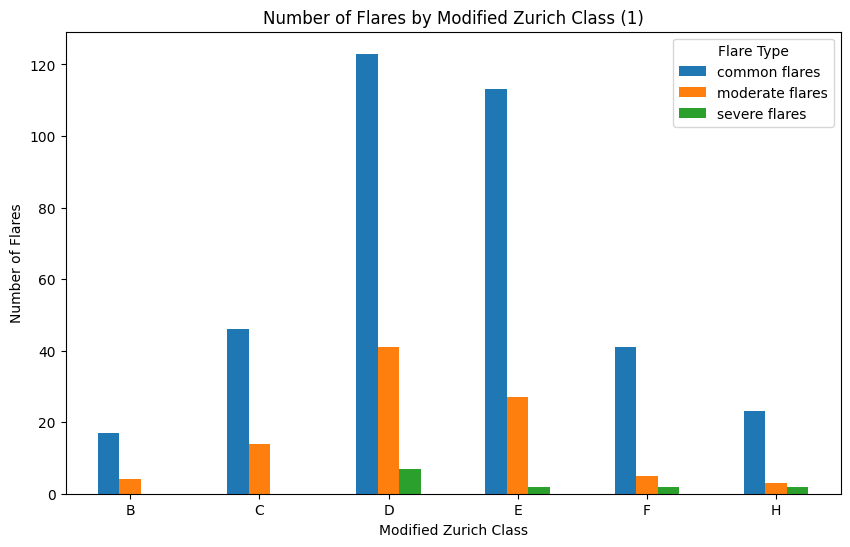

In [11]:
# grouping so it's easier to handle
zurich_classes = ['zurich_class_B', 'zurich_class_C', 'zurich_class_D', 'zurich_class_E', 'zurich_class_F', 'zurich_class_H']
df_flare_xencoded['zurich_class'] = df_flare_xencoded[zurich_classes].idxmax(axis=1).str.replace('zurich_class_', '')
flare_counts_by_zurich_class = df_flare_xencoded.groupby('zurich_class')[['common flares', 'moderate flares', 'severe flares']].sum()

# Plotting (I plotted this differently than what we learned to do since I had the x and y values in the same dataframe)
flare_counts_by_zurich_class.plot(kind='bar', figsize=(10, 6))
plt.title('Number of Flares by Modified Zurich Class (1)')
plt.xlabel('Modified Zurich Class')
plt.ylabel('Number of Flares')
plt.xticks(rotation=0)
plt.legend(title='Flare Type')
plt.show()

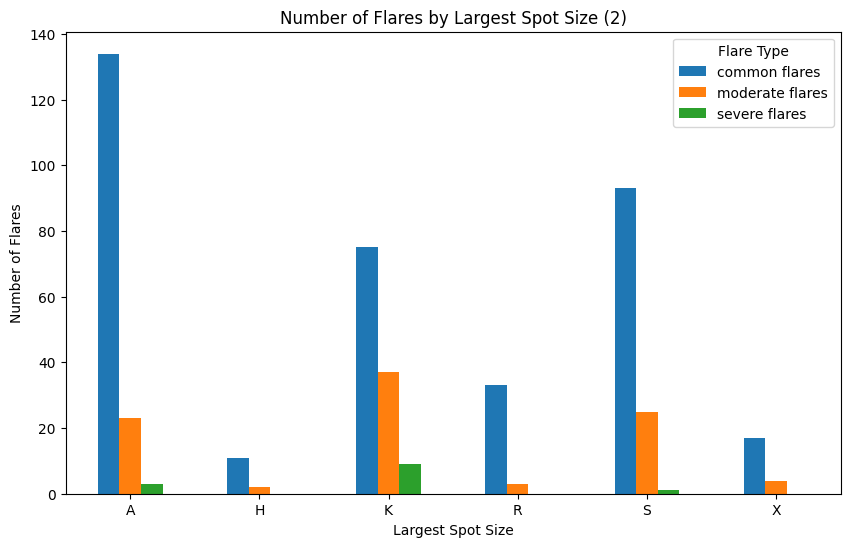

In [12]:
largest_spot_sizes = ['largest_spot_size_X', 'largest_spot_size_R', 'largest_spot_size_S', 'largest_spot_size_A', 'largest_spot_size_H', 'largest_spot_size_K']
df_flare_xencoded['largest_spot_size'] = df_flare_xencoded[largest_spot_sizes].idxmax(axis=1).str.replace('largest_spot_size_', '')
flare_counts_by_largest_spot_size = df_flare_xencoded.groupby('largest_spot_size')[['common flares', 'moderate flares', 'severe flares']].sum()

flare_counts_by_largest_spot_size.plot(kind='bar', figsize=(10, 6))
plt.title('Number of Flares by Largest Spot Size (2)')
plt.xlabel('Largest Spot Size')
plt.ylabel('Number of Flares')
plt.xticks(rotation=0)
plt.legend(title='Flare Type')
plt.show()

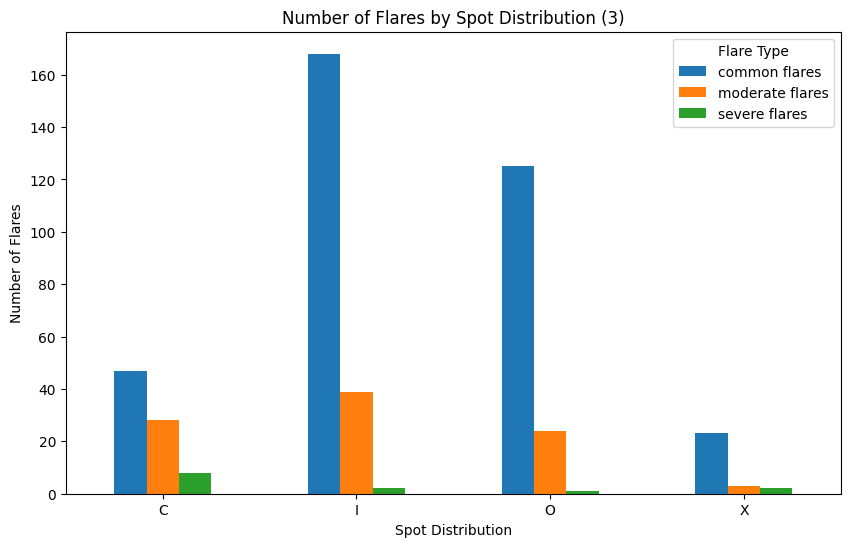

In [13]:
spot_distributions = ['spot_distribution_X', 'spot_distribution_O', 'spot_distribution_I', 'spot_distribution_C']
df_flare_xencoded['spot_distribution'] = df_flare_xencoded[spot_distributions].idxmax(axis=1).str.replace('spot_distribution_', '')
flare_counts_by_spot_distribution = df_flare_xencoded.groupby('spot_distribution')[['common flares', 'moderate flares', 'severe flares']].sum()

flare_counts_by_spot_distribution.plot(kind='bar', figsize=(10, 6))
plt.title('Number of Flares by Spot Distribution (3)')
plt.xlabel('Spot Distribution')
plt.ylabel('Number of Flares')
plt.xticks(rotation=0)
plt.legend(title='Flare Type')
plt.show()

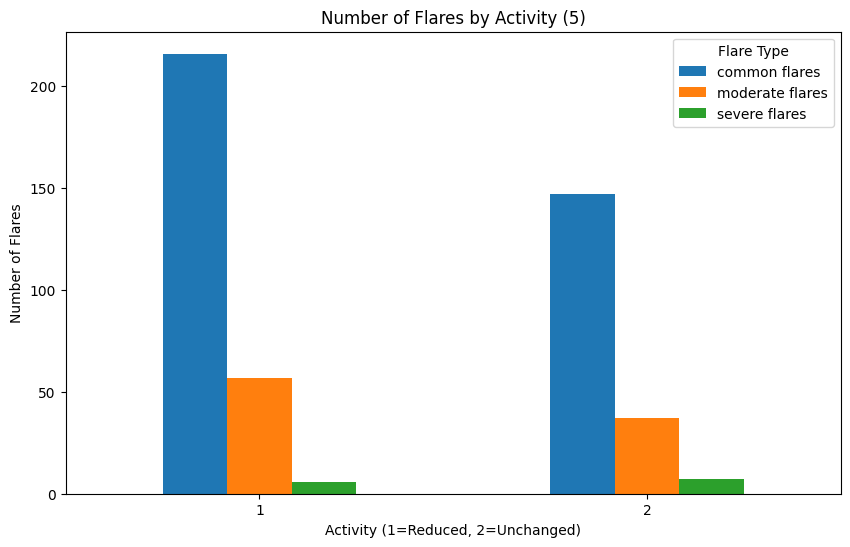

In [14]:
# plot for activity vs flares
flare_counts_by_activity = df_flare_xencoded.groupby('activity')[['common flares', 'moderate flares', 'severe flares']].sum()

flare_counts_by_activity.plot(kind='bar', figsize=(10, 6))
plt.title('Number of Flares by Activity (5)')
plt.xlabel('Activity (1=Reduced, 2=Unchanged)')
plt.ylabel('Number of Flares')
plt.legend(title='Flare Type')
plt.xticks(rotation=0)
plt.show()

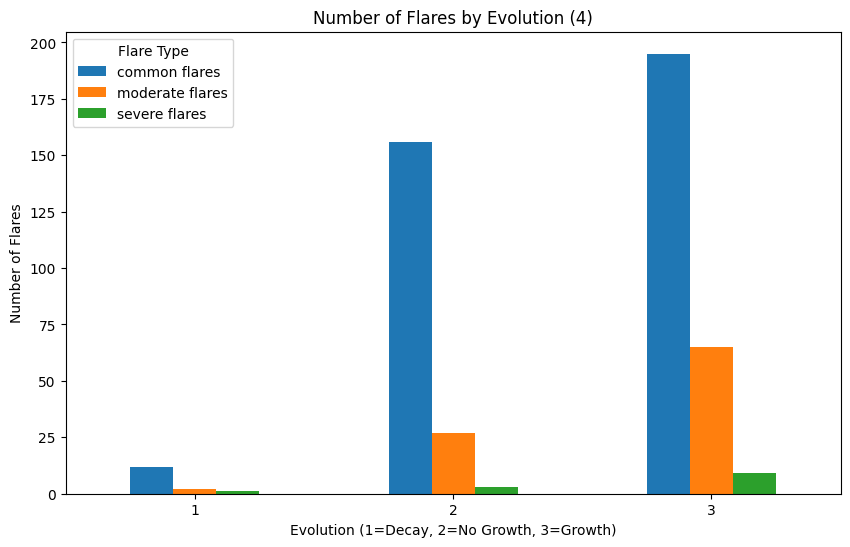

In [15]:
# plot for evolution vs flares
flare_counts_by_evolution = df_flare_xencoded.groupby('evolution')[['common flares', 'moderate flares', 'severe flares']].sum()

flare_counts_by_evolution.plot(kind='bar', figsize=(10, 6))
plt.title('Number of Flares by Evolution (4)')
plt.xlabel('Evolution (1=Decay, 2=No Growth, 3=Growth)')
plt.ylabel('Number of Flares')
plt.legend(title='Flare Type')
plt.xticks(rotation=0)
plt.show()

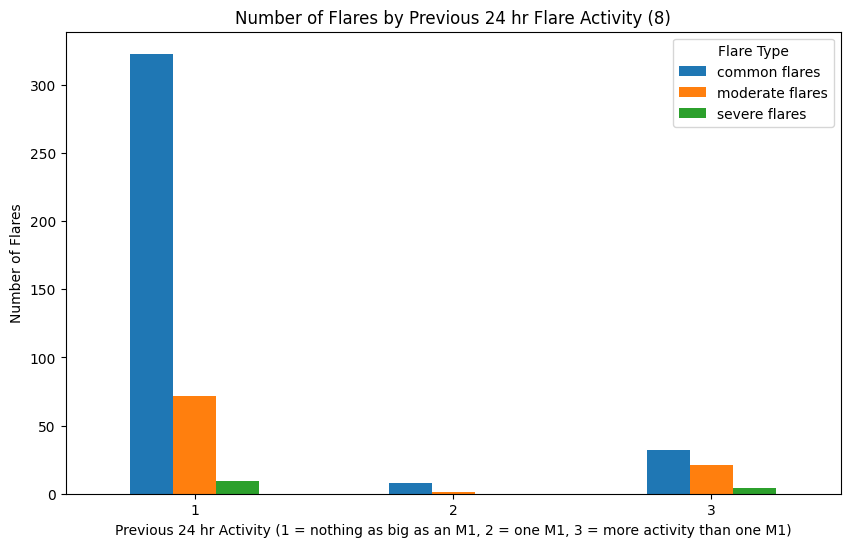

In [16]:
# plot for previous 24 hour flare activity vs flares
flare_counts_by_prev_activity = df_flare_xencoded.groupby('previous 24 hour flare activity')[['common flares', 'moderate flares', 'severe flares']].sum()

flare_counts_by_prev_activity.plot(kind='bar', figsize=(10, 6))
plt.title('Number of Flares by Previous 24 hr Flare Activity (8)')
plt.xlabel('Previous 24 hr Activity (1 = nothing as big as an M1, 2 = one M1, 3 = more activity than one M1)')
plt.ylabel('Number of Flares')
plt.legend(title='Flare Type')
plt.xticks(rotation=0)
plt.show()


# Historically-complex (1 = Yes, 2 = No)

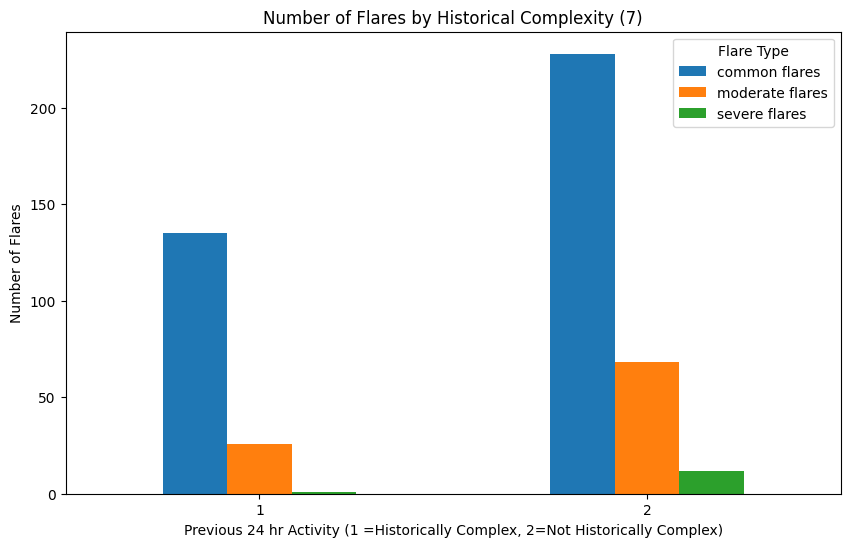

In [17]:
# plot for historical complexity vs flares
flare_counts_by_historical_complexity = df_flare_xencoded.groupby('historically-complex')[['common flares', 'moderate flares', 'severe flares']].sum()

flare_counts_by_historical_complexity.plot(kind='bar', figsize=(10, 6))
plt.title('Number of Flares by Historical Complexity (7)')
plt.xlabel('Previous 24 hr Activity (1 =Historically Complex, 2=Not Historically Complex)')
plt.ylabel('Number of Flares')
plt.legend(title='Flare Type')
plt.xticks(rotation=0)
plt.show()

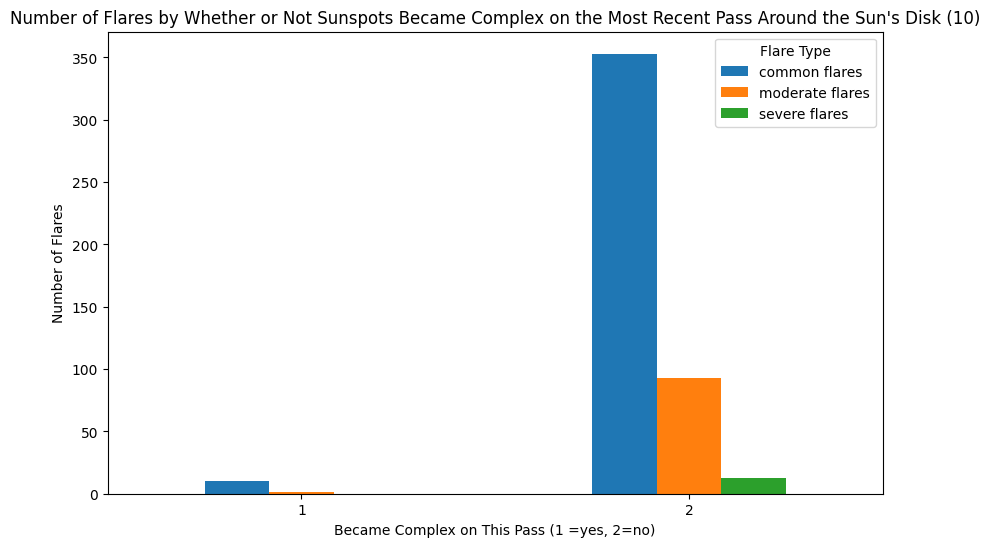

In [18]:
# plot for becoming complex on the most recent pass across the sun's disk vs flares
flare_counts_by_complex_this_pass = df_flare_xencoded.groupby('became complex on this pass')[['common flares', 'moderate flares', 'severe flares']].sum()

flare_counts_by_complex_this_pass.plot(kind='bar', figsize=(10, 6))
plt.title("Number of Flares by Whether or Not Sunspots Became Complex on the Most Recent Pass Around the Sun's Disk (10)")
plt.xlabel('Became Complex on This Pass (1 =yes, 2=no)')
plt.ylabel('Number of Flares')
plt.legend(title='Flare Type')
plt.xticks(rotation=0)
plt.show()

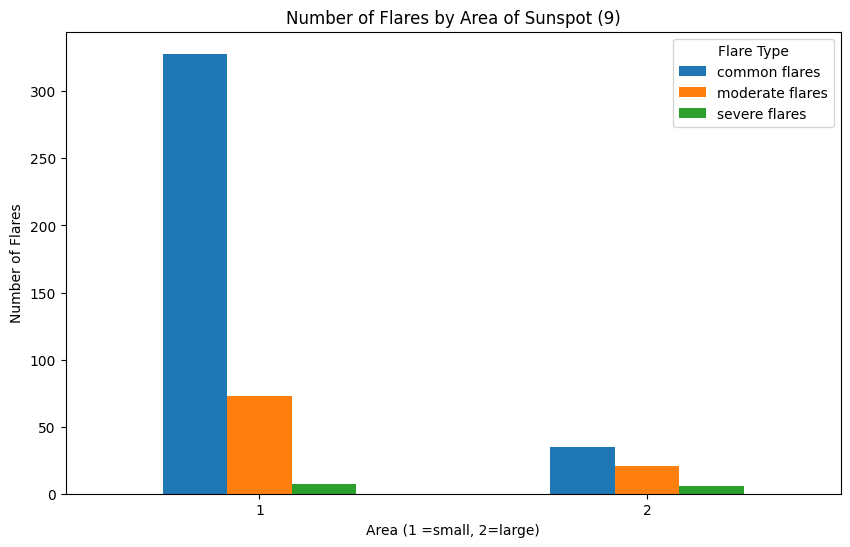

In [19]:
# plot for area vs flares
flare_counts_by_area = df_flare_xencoded.groupby('area')[['common flares', 'moderate flares', 'severe flares']].sum()

flare_counts_by_area.plot(kind='bar', figsize=(10, 6))
plt.title("Number of Flares by Area of Sunspot (9)")
plt.xlabel('Area (1 =small, 2=large)')
plt.ylabel('Number of Flares')
plt.legend(title='Flare Type')
plt.xticks(rotation=0)
plt.show()

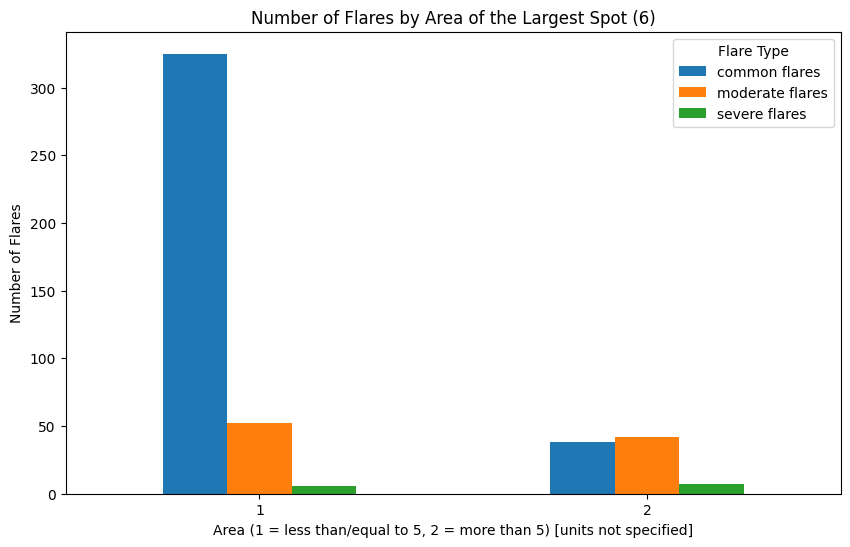

In [20]:
# plot for area of largest spot vs flares
flare_counts_by_area_lgest_spot = df_flare_xencoded.groupby('area of largest spot')[['common flares', 'moderate flares', 'severe flares']].sum()

flare_counts_by_area_lgest_spot.plot(kind='bar', figsize=(10, 6))
plt.title("Number of Flares by Area of the Largest Spot (6)")
plt.xlabel('Area (1 = less than/equal to 5, 2 = more than 5) [units not specified]')
plt.ylabel('Number of Flares')
plt.legend(title='Flare Type')
plt.xticks(rotation=0)
plt.show()

### Research Question:
How does modified Zurich class and sunspot distribution affect the total amount of X class flares?

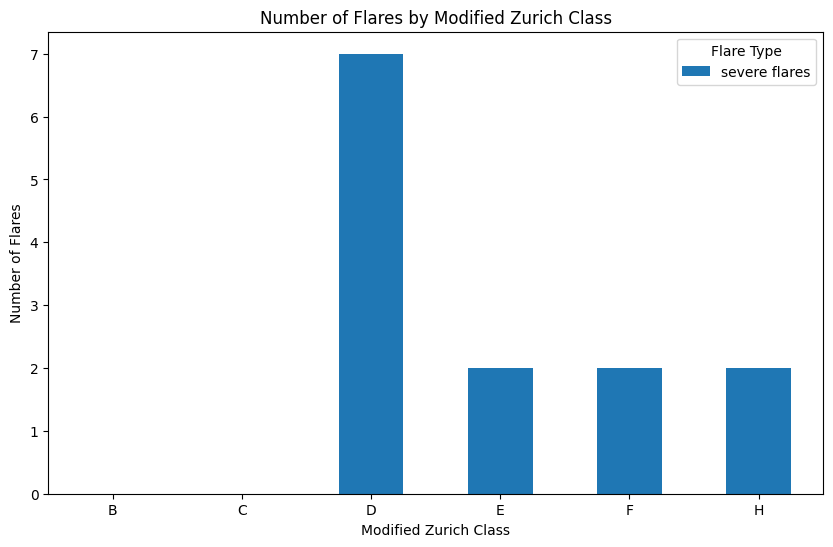

In [21]:
x_flare_counts_by_zurich_class = df_flare_xencoded.groupby('zurich_class')['severe flares'].sum()

x_flare_counts_by_zurich_class.plot(kind='bar', figsize=(10, 6))
plt.title('Number of Flares by Modified Zurich Class')
plt.xlabel('Modified Zurich Class')
plt.ylabel('Number of Flares')
plt.xticks(rotation=0)
plt.legend(title='Flare Type')
plt.show()

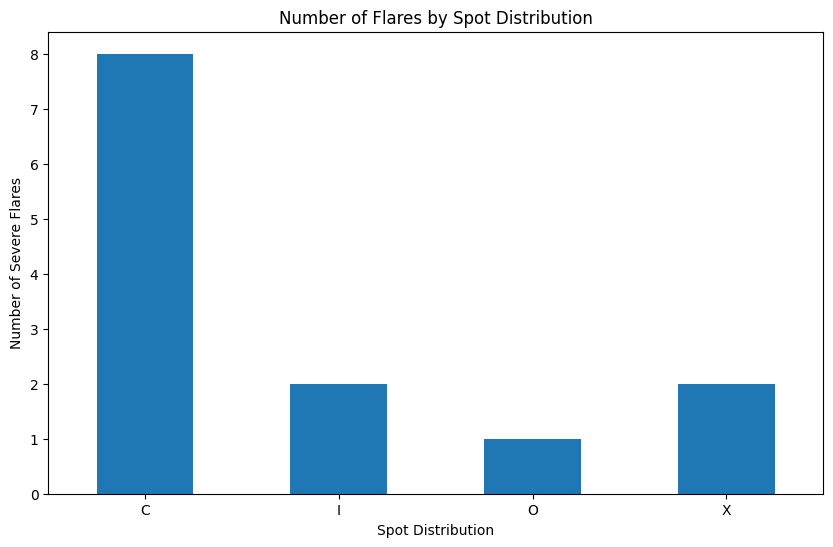

In [22]:
x_flare_counts_by_spot_distribution = df_flare_xencoded.groupby('spot_distribution')['severe flares'].sum()

x_flare_counts_by_spot_distribution.plot(kind='bar', figsize=(10, 6))
plt.title('Number of Flares by Spot Distribution')
plt.xlabel('Spot Distribution')
plt.ylabel('Number of Severe Flares')
plt.xticks(rotation=0)
plt.show()

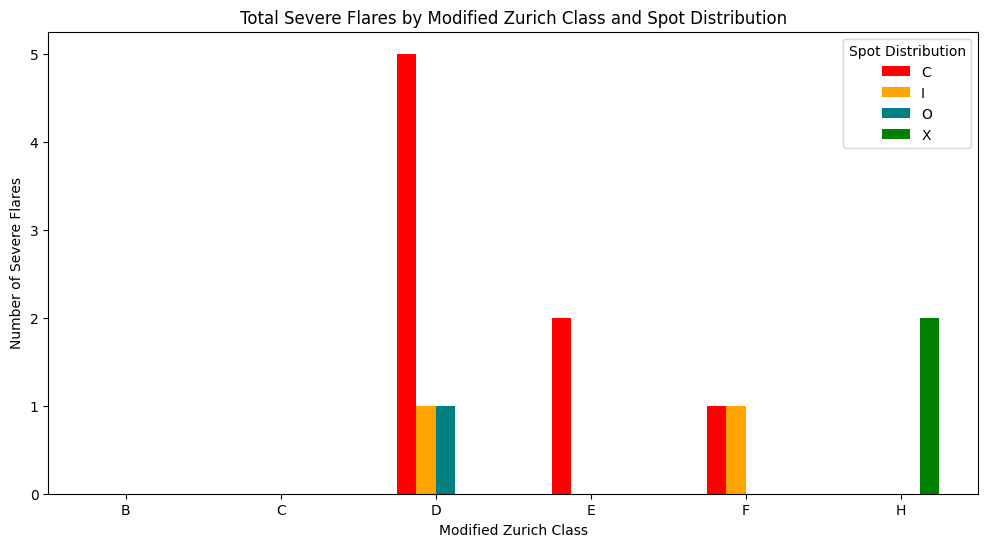

In [23]:
x_flare_counts_by_zurich_and_spot = df_flare_xencoded.groupby(['zurich_class', 'spot_distribution'])['severe flares'].sum().unstack()

# Plotting as a grouped bar chart
x_flare_counts_by_zurich_and_spot.plot(kind='bar', color=['red', 'orange', 'teal', 'green'], figsize=(12,6))
plt.title('Total Severe Flares by Modified Zurich Class and Spot Distribution')
plt.xlabel('Modified Zurich Class')
plt.ylabel('Number of Severe Flares')
plt.xticks(rotation=0)
plt.legend(title='Spot Distribution')
plt.show()

In [24]:
# 2-way Anova test

Xy = pd.concat([X, y], axis=1)

Xy['modified_Zurich_class'] = Xy['modified Zurich class'].astype('category')
Xy['spot_distribution'] = Xy['spot distribution'].astype('category')
Xy['severe_flares'] = Xy['severe flares']

model = ols('severe_flares ~ C(modified_Zurich_class) + C(spot_distribution) + C(modified_Zurich_class):C(spot_distribution)', data=Xy).fit()

anova_results = sm.stats.anova_lm(model, typ=2) # typ=2 is balanced, typ=3 unbalanced
print(anova_results)

                                                  sum_sq      df         F  \
C(modified_Zurich_class)                             NaN     5.0       NaN   
C(spot_distribution)                                 NaN     3.0       NaN   
C(modified_Zurich_class):C(spot_distribution)   0.000547    15.0  0.003695   
Residual                                       13.563127  1375.0       NaN   

                                                 PR(>F)  
C(modified_Zurich_class)                            NaN  
C(spot_distribution)                                NaN  
C(modified_Zurich_class):C(spot_distribution)  0.951537  
Residual                                            NaN  


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 5, but rank is 0
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 0
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 15, but rank is 1
  warnings.warn('covariance of constraints does not have full '
